In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import numpy as np

# Label ID to Train ID mapping
ID_TO_TRAINID = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 7: 0,
    8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255, 15: 255,
    16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10,
    24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 255, 30: 255,
    31: 16, 32: 17, 33: 18
}
def convert_label(label):
    label = np.array(label)
    converted = np.full(label.shape, 255, dtype=np.uint8)  # 255 = ignore
    for id_, train_id in ID_TO_TRAINID.items():
        converted[label == id_] = train_id
    return Image.fromarray(converted)

class CityscapesDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None, label_transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.label_transform = label_transform
       
        self.image_paths = [os.path.join(image_folder, x) for x in os.listdir(image_folder) if x.endswith('.png')]
        self.label_paths = [os.path.join(label_folder, x) for x in os.listdir(label_folder) if x.endswith('gtFine_labelIds.png')]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        label = convert_label(label)
        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label



image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing image
])


# Label transformation without normalization (just resizing and converting to tensor)
label_transform = transforms.Compose([  
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0).long()), # Convert into from 1*H*W to H*W format and long type for Cross entropy

 # Convert label mask to tensor, no normalization
])




In [15]:
# Usage of dataset and dataloader
from torch.utils.data import DataLoader

dataset = CityscapesDataset(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/train_final',
    label_folder='D:/Citscapes dataset/Output/train_final',
    transform=image_transform,
    label_transform=label_transform  
)




Unique class IDs and their counts:
Class ID: 0, Count: 419830
Class ID: 1, Count: 8196
Class ID: 2, Count: 38854
Class ID: 5, Count: 17591
Class ID: 6, Count: 8724
Class ID: 7, Count: 5319
Class ID: 8, Count: 301607
Class ID: 9, Count: 10924
Class ID: 10, Count: 59775
Class ID: 11, Count: 9648
Class ID: 13, Count: 102565
Class ID: 15, Count: 1748
Class ID: 255, Count: 63795


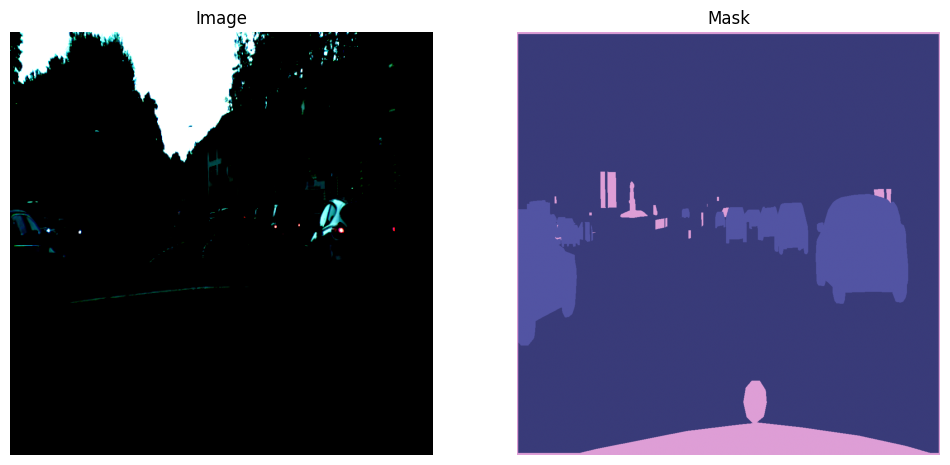

Unique class IDs and their counts:
Class ID: 0, Count: 363650
Class ID: 1, Count: 11722
Class ID: 2, Count: 342377
Class ID: 5, Count: 1999
Class ID: 8, Count: 15136
Class ID: 10, Count: 37540
Class ID: 11, Count: 1060
Class ID: 13, Count: 203210
Class ID: 14, Count: 3975
Class ID: 18, Count: 5543
Class ID: 255, Count: 62364


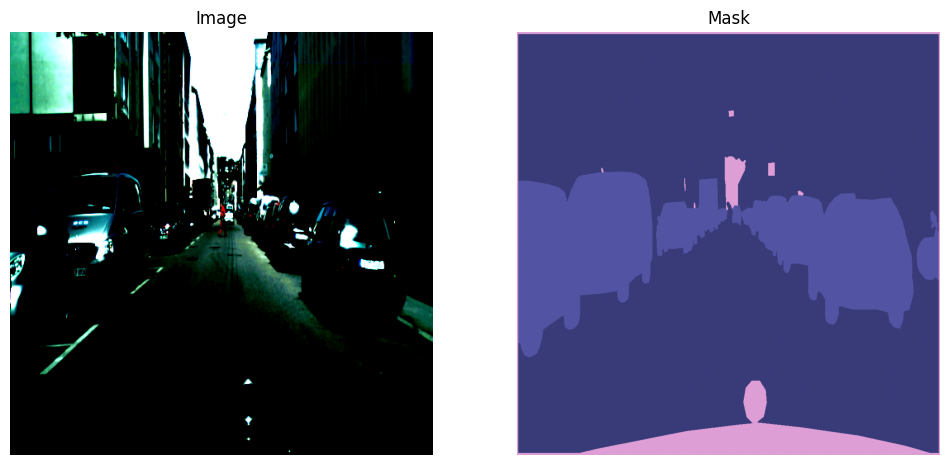

Unique class IDs and their counts:
Class ID: 0, Count: 354553
Class ID: 1, Count: 84060
Class ID: 2, Count: 261768
Class ID: 4, Count: 22857
Class ID: 5, Count: 13769
Class ID: 6, Count: 981
Class ID: 7, Count: 13262
Class ID: 8, Count: 59809
Class ID: 10, Count: 51424
Class ID: 11, Count: 62079
Class ID: 12, Count: 227
Class ID: 13, Count: 1401
Class ID: 18, Count: 806
Class ID: 255, Count: 121580


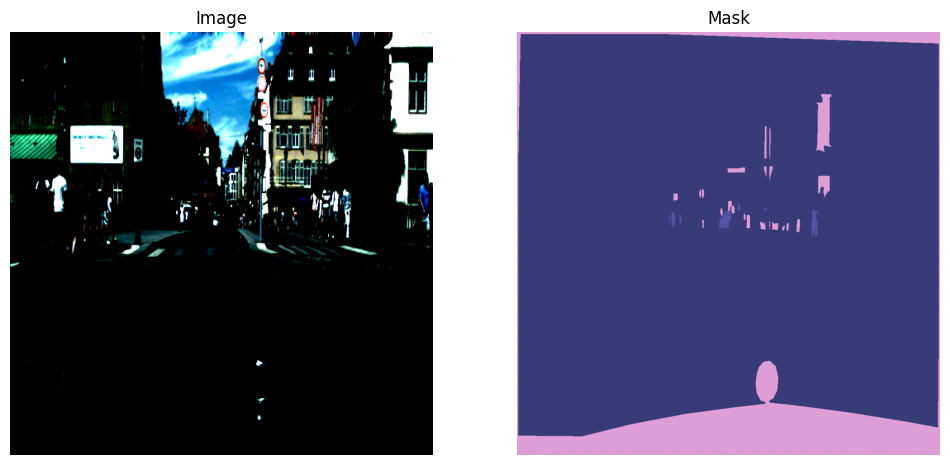

Unique class IDs and their counts:
Class ID: 0, Count: 478466
Class ID: 1, Count: 21742
Class ID: 2, Count: 67450
Class ID: 3, Count: 8554
Class ID: 5, Count: 14358
Class ID: 6, Count: 4966
Class ID: 7, Count: 4192
Class ID: 8, Count: 286224
Class ID: 9, Count: 1082
Class ID: 10, Count: 56032
Class ID: 11, Count: 2542
Class ID: 13, Count: 15659
Class ID: 18, Count: 3938
Class ID: 255, Count: 83371


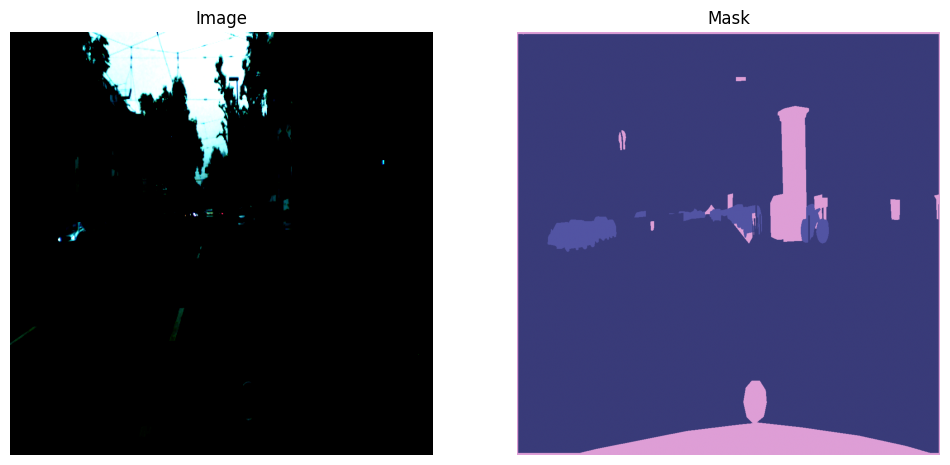

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Function to display image and mask side-by-side
def visualize_image_and_mask(image, mask):
    # Convert tensor to numpy for display
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
    image = np.clip(image, 0, 1)  # Ensure pixel values are between 0 and 1

    # Plot image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis('off')  # Hide axes

    # Display the mask
    ax[1].imshow(mask, cmap='tab20b')  # Use 'tab20b' colormap for easy visualization of different classes
    ax[1].set_title("Mask")
    ax[1].axis('off')  # Hide axes

    plt.show()

# Function to convert mask to image (optional, if you need color map)
def convert_mask_to_image(mask):
    mask = mask.cpu().numpy()  # Convert tensor to numpy array
    return mask

# Function to print unique class IDs and their counts in the mask
def print_unique_classes_and_counts(mask):
    unique_values, counts = torch.unique(mask, return_counts=True)  # Get unique IDs and their counts
    print("Unique class IDs and their counts:")
    for i in range(len(unique_values)):
        print(f"Class ID: {unique_values[i].item()}, Count: {counts[i].item()}")

# Visualize first batch of images and masks
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get a batch of images and labels (masks)
for images, labels in dataloader:
    for i in range(images.size(0)):  # Iterate over each image in the batch
        img = images[i]  # Image
        mask = labels[i]  # Corresponding mask

        # Print the unique class IDs and their counts for the mask
        print_unique_classes_and_counts(mask)

        # Visualize the image and mask
        visualize_image_and_mask(img, convert_mask_to_image(mask))

    break  # Break after first batch for illustration (you can remove this to process the entire dataset)
